In [ ]:
import os
import random
import matplotlib.pyplot as plt
import torch
import gc
gc.collect()
torch.cuda.empty_cache()


WORKING_DIR = '/kaggle/working/'
image_directory = "/kaggle/input/0-3-5-dataset/0.3.5/Images"
mask_directory = "/kaggle/input/0-3-5-dataset/0.3.5/Masks"
SIZE = (128,256)
LEARNING_RATE = 3e-4
BATCH_SIZE = 32
NUM_CLASS = 2
EPOCHS = 30

if (os.path.exists(WORKING_DIR + 'checkpoint') == False):
    os.mkdir(WORKING_DIR + 'checkpoint')
if (os.path.exists(WORKING_DIR + 'final') == False):
    os.mkdir(WORKING_DIR + 'final')

In [2]:
import glob
import os
import re
import torch
from torch.utils.data import Dataset, random_split
from torchvision.transforms import v2 as transforms
from PIL import Image
import numpy as np
            
class SimDataset(Dataset):
  def __init__(self, image_paths, mask_paths_left, mask_paths_right, transform_img=None, transform_mask=None):
    self.image_paths = image_paths
    self.mask_paths_left = mask_paths_left
    self.mask_paths_right = mask_paths_right
    self.transform_img = transform_img
    self.transform_mask = transform_mask

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    img_path = self.image_paths[idx]
    mask_path_left = self.mask_paths_left[idx]
    mask_path_right = self.mask_paths_right[idx]

    mask_left = Image.open(mask_path_left).convert("L") # convert("L") will convert the image to grayscale
    mask_right = Image.open(mask_path_right).convert("L") # convert("L") will convert the image to grayscale
    if self.transform_mask:
        mask_left = self.transform_mask(mask_left)
        mask_right = self.transform_mask(mask_right)
        mask = torch.tensor(np.array([mask_left[0], mask_right[0]]))
        mask[mask > 0.0] = 1

    image = Image.open(img_path).convert("RGB") # we might not need to do this because the images are loaded as RGB by default
    if self.transform_img:
      image = self.transform_img(image)
    return [image, mask]


image_paths = sorted(glob.glob(os.path.join(image_directory, "*.png")), key=lambda x:float(re.findall("(\d+)",x)[-1]))
mask_paths_left = sorted(glob.glob(os.path.join(mask_directory, "*-left.png")), key=lambda x:float(re.findall("(\d+)",x)[-1]))
mask_paths_right = sorted(glob.glob(os.path.join(mask_directory, "*-right.png")), key=lambda x:float(re.findall("(\d+)",x)[-1]))
assert len(mask_paths_left) == len(mask_paths_right), "Amount of left and right mask is no"
assert len(image_paths) == len(mask_paths_left), "Amount of images and label are different"
dataset = SimDataset(image_paths,
                     mask_paths_left,
                     mask_paths_right,
                     transforms.Compose([
                                         transforms.Resize(SIZE),
                                         transforms.ColorJitter(brightness=.5, hue=.3),
                                         transforms.ToTensor()
                                         #transforms.ToImage(),
                                         #transforms.ToDtype(torch.float32, scale=True),
                                         # transforms.Normalize(mean=[0.0],
                                         #                      std=[1.0])
                                                              ]),
                     transforms.Compose([
                                         transforms.Resize(SIZE),
                                         transforms.ToTensor()
                                         #transforms.ToImage(),
                                         #transforms.ToDtype(torch.float32, scale=True),
                                         # transforms.Normalize(mean=[0.0],
                                         #                       std=[1.0])
                                                              ]))
generator = torch.Generator().manual_seed(25)
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2], generator=generator)
test_dataset, val_dataset = random_split(test_dataset, [0.25, 0.75], generator=generator)


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [3]:
import torch
import torch.nn as nn
from torch import nn

# https://medium.com/@fernandopalominocobo/mastering-u-net-a-step-by-step-guide-to-segmentation-from-scratch-with-pytorch-6a17c5916114
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out


In [4]:
import torch
import torch.nn as nn
from torch import optim, nn
from torch.utils.data import DataLoader
from tqdm import tqdm

torch.cuda.empty_cache()

device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    num_workers = torch.cuda.device_count() * 4
else:
    num_workers = 1

train_dataloader = DataLoader(dataset=train_dataset,
                              num_workers=num_workers, pin_memory=False,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            num_workers=num_workers, pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             num_workers=num_workers, pin_memory=False,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

In [5]:
# model_pth = '/kaggle/working/final/final_epoch30.pth'

model = UNet(in_channels=3, num_classes=NUM_CLASS).to(device)
# model.load_state_dict(torch.load(model_pth,weights_only=True, map_location=torch.device(device)))
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss().to(device=device)
scaler = torch.amp.GradScaler('cuda')

def dice_coefficient(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.float().clone()
    target = target.float()

    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1

    intersection = abs(torch.sum(prediction_copy * target))
    union = abs(torch.sum(prediction_copy) + torch.sum(target))
    dice = (2. * intersection + epsilon) / (union + epsilon)

    return dice


torch.cuda.empty_cache()

train_losses = []
train_dcs = []
val_losses = []
val_dcs = []

for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_running_loss = 0
    train_running_dc = 0

    for idx, img_mask in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            y_pred = model(img)

            dc = dice_coefficient(y_pred, mask)
            loss = criterion(y_pred, mask)

        train_running_loss += loss.item()
        train_running_dc += dc.item()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    train_loss = train_running_loss / (idx + 1)
    train_dc = train_running_dc / (idx + 1)

    train_losses.append(train_loss)
    train_dcs.append(train_dc)

    model.eval()
    val_running_loss = 0
    val_running_dc = 0

    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)

            with torch.amp.autocast('cuda'):
                y_pred = model(img)
                loss = criterion(y_pred, mask)
                dc = dice_coefficient(y_pred, mask)

            val_running_loss += loss.item()
            val_running_dc += dc.item()

        val_loss = val_running_loss / (idx + 1)
        val_dc = val_running_dc / (idx + 1)

    val_losses.append(val_loss)
    val_dcs.append(val_dc)

    print("-" * 30)
    print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
    print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
    print("\n")
    print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
    print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")
    print("-" * 30)
    if (epoch > 9 and epoch % 10 == 0):
        torch.save(model.state_dict(), f"checkpoint/checkpoint_epoch{epoch}.pth")

# Saving the model
torch.save(model.state_dict(), f'final/final_epoch{EPOCHS}_fp16.pth')

  3%|▎         | 1/30 [00:38<18:47, 38.89s/it]

------------------------------
Training Loss EPOCH 1: 0.2732
Training DICE EPOCH 1: 0.0022


Validation Loss EPOCH 1: 0.1438
Validation DICE EPOCH 1: 0.0000
------------------------------


  7%|▋         | 2/30 [01:15<17:30, 37.50s/it]

------------------------------
Training Loss EPOCH 2: 0.1174
Training DICE EPOCH 2: 0.1373


Validation Loss EPOCH 2: 0.1033
Validation DICE EPOCH 2: 0.3814
------------------------------


 10%|█         | 3/30 [01:52<16:42, 37.11s/it]

------------------------------
Training Loss EPOCH 3: 0.0898
Training DICE EPOCH 3: 0.4241


Validation Loss EPOCH 3: 0.0859
Validation DICE EPOCH 3: 0.4660
------------------------------


 13%|█▎        | 4/30 [02:29<16:05, 37.13s/it]

------------------------------
Training Loss EPOCH 4: 0.0727
Training DICE EPOCH 4: 0.6344


Validation Loss EPOCH 4: 0.0727
Validation DICE EPOCH 4: 0.6768
------------------------------


 17%|█▋        | 5/30 [03:05<15:23, 36.93s/it]

------------------------------
Training Loss EPOCH 5: 0.0578
Training DICE EPOCH 5: 0.7340


Validation Loss EPOCH 5: 0.0551
Validation DICE EPOCH 5: 0.7403
------------------------------


 20%|██        | 6/30 [03:42<14:43, 36.80s/it]

------------------------------
Training Loss EPOCH 6: 0.0495
Training DICE EPOCH 6: 0.7746


Validation Loss EPOCH 6: 0.0492
Validation DICE EPOCH 6: 0.7758
------------------------------


 23%|██▎       | 7/30 [04:18<14:03, 36.68s/it]

------------------------------
Training Loss EPOCH 7: 0.0436
Training DICE EPOCH 7: 0.8047


Validation Loss EPOCH 7: 0.0431
Validation DICE EPOCH 7: 0.8223
------------------------------


 27%|██▋       | 8/30 [04:55<13:25, 36.61s/it]

------------------------------
Training Loss EPOCH 8: 0.0360
Training DICE EPOCH 8: 0.8466


Validation Loss EPOCH 8: 0.0355
Validation DICE EPOCH 8: 0.8581
------------------------------


 30%|███       | 9/30 [05:31<12:48, 36.58s/it]

------------------------------
Training Loss EPOCH 9: 0.0327
Training DICE EPOCH 9: 0.8668


Validation Loss EPOCH 9: 0.0312
Validation DICE EPOCH 9: 0.8750
------------------------------


 33%|███▎      | 10/30 [06:08<12:10, 36.51s/it]

------------------------------
Training Loss EPOCH 10: 0.0283
Training DICE EPOCH 10: 0.8853


Validation Loss EPOCH 10: 0.0337
Validation DICE EPOCH 10: 0.8707
------------------------------


100%|██████████| 17/17 [00:03<00:00,  4.26it/s]


------------------------------
Training Loss EPOCH 11: 0.0251
Training DICE EPOCH 11: 0.8975


Validation Loss EPOCH 11: 0.0263
Validation DICE EPOCH 11: 0.8947
------------------------------


 40%|████      | 12/30 [07:21<10:59, 36.63s/it]

------------------------------
Training Loss EPOCH 12: 0.0230
Training DICE EPOCH 12: 0.9065


Validation Loss EPOCH 12: 0.0249
Validation DICE EPOCH 12: 0.9003
------------------------------


 43%|████▎     | 13/30 [07:58<10:21, 36.57s/it]

------------------------------
Training Loss EPOCH 13: 0.0235
Training DICE EPOCH 13: 0.9056


Validation Loss EPOCH 13: 0.0285
Validation DICE EPOCH 13: 0.8927
------------------------------


 47%|████▋     | 14/30 [08:34<09:44, 36.54s/it]

------------------------------
Training Loss EPOCH 14: 0.0214
Training DICE EPOCH 14: 0.9137


Validation Loss EPOCH 14: 0.0242
Validation DICE EPOCH 14: 0.9096
------------------------------


 50%|█████     | 15/30 [09:11<09:07, 36.50s/it]

------------------------------
Training Loss EPOCH 15: 0.0196
Training DICE EPOCH 15: 0.9205


Validation Loss EPOCH 15: 0.0223
Validation DICE EPOCH 15: 0.9132
------------------------------


 53%|█████▎    | 16/30 [09:47<08:30, 36.49s/it]

------------------------------
Training Loss EPOCH 16: 0.0199
Training DICE EPOCH 16: 0.9188


Validation Loss EPOCH 16: 0.0220
Validation DICE EPOCH 16: 0.9171
------------------------------


 57%|█████▋    | 17/30 [10:24<07:54, 36.51s/it]

------------------------------
Training Loss EPOCH 17: 0.0181
Training DICE EPOCH 17: 0.9263


Validation Loss EPOCH 17: 0.0187
Validation DICE EPOCH 17: 0.9263
------------------------------


 60%|██████    | 18/30 [11:01<07:19, 36.64s/it]

------------------------------
Training Loss EPOCH 18: 0.0174
Training DICE EPOCH 18: 0.9289


Validation Loss EPOCH 18: 0.0185
Validation DICE EPOCH 18: 0.9278
------------------------------


 63%|██████▎   | 19/30 [11:37<06:42, 36.56s/it]

------------------------------
Training Loss EPOCH 19: 0.0167
Training DICE EPOCH 19: 0.9320


Validation Loss EPOCH 19: 0.0200
Validation DICE EPOCH 19: 0.9218
------------------------------


 67%|██████▋   | 20/30 [12:13<06:05, 36.51s/it]

------------------------------
Training Loss EPOCH 20: 0.0159
Training DICE EPOCH 20: 0.9348


Validation Loss EPOCH 20: 0.0181
Validation DICE EPOCH 20: 0.9288
------------------------------


100%|██████████| 17/17 [00:03<00:00,  4.76it/s]


------------------------------
Training Loss EPOCH 21: 0.0154
Training DICE EPOCH 21: 0.9362


Validation Loss EPOCH 21: 0.0176
Validation DICE EPOCH 21: 0.9330
------------------------------


 73%|███████▎  | 22/30 [13:26<04:52, 36.52s/it]

------------------------------
Training Loss EPOCH 22: 0.0142
Training DICE EPOCH 22: 0.9410


Validation Loss EPOCH 22: 0.0170
Validation DICE EPOCH 22: 0.9365
------------------------------


 77%|███████▋  | 23/30 [14:03<04:15, 36.52s/it]

------------------------------
Training Loss EPOCH 23: 0.0144
Training DICE EPOCH 23: 0.9400


Validation Loss EPOCH 23: 0.0168
Validation DICE EPOCH 23: 0.9338
------------------------------


 80%|████████  | 24/30 [14:39<03:38, 36.48s/it]

------------------------------
Training Loss EPOCH 24: 0.0147
Training DICE EPOCH 24: 0.9394


Validation Loss EPOCH 24: 0.0188
Validation DICE EPOCH 24: 0.9310
------------------------------


 83%|████████▎ | 25/30 [15:16<03:02, 36.57s/it]

------------------------------
Training Loss EPOCH 25: 0.0137
Training DICE EPOCH 25: 0.9435


Validation Loss EPOCH 25: 0.0157
Validation DICE EPOCH 25: 0.9415
------------------------------


 87%|████████▋ | 26/30 [15:53<02:26, 36.54s/it]

------------------------------
Training Loss EPOCH 26: 0.0131
Training DICE EPOCH 26: 0.9454


Validation Loss EPOCH 26: 0.0174
Validation DICE EPOCH 26: 0.9371
------------------------------


 90%|█████████ | 27/30 [16:29<01:49, 36.51s/it]

------------------------------
Training Loss EPOCH 27: 0.0125
Training DICE EPOCH 27: 0.9479


Validation Loss EPOCH 27: 0.0150
Validation DICE EPOCH 27: 0.9429
------------------------------


 93%|█████████▎| 28/30 [17:05<01:12, 36.48s/it]

------------------------------
Training Loss EPOCH 28: 0.0120
Training DICE EPOCH 28: 0.9498


Validation Loss EPOCH 28: 0.0150
Validation DICE EPOCH 28: 0.9459
------------------------------


 97%|█████████▋| 29/30 [17:42<00:36, 36.47s/it]

------------------------------
Training Loss EPOCH 29: 0.0123
Training DICE EPOCH 29: 0.9487


Validation Loss EPOCH 29: 0.0163
Validation DICE EPOCH 29: 0.9416
------------------------------


100%|██████████| 30/30 [18:18<00:00, 36.62s/it]


------------------------------
Training Loss EPOCH 30: 0.0111
Training DICE EPOCH 30: 0.9534


Validation Loss EPOCH 30: 0.0148
Validation DICE EPOCH 30: 0.9446
------------------------------


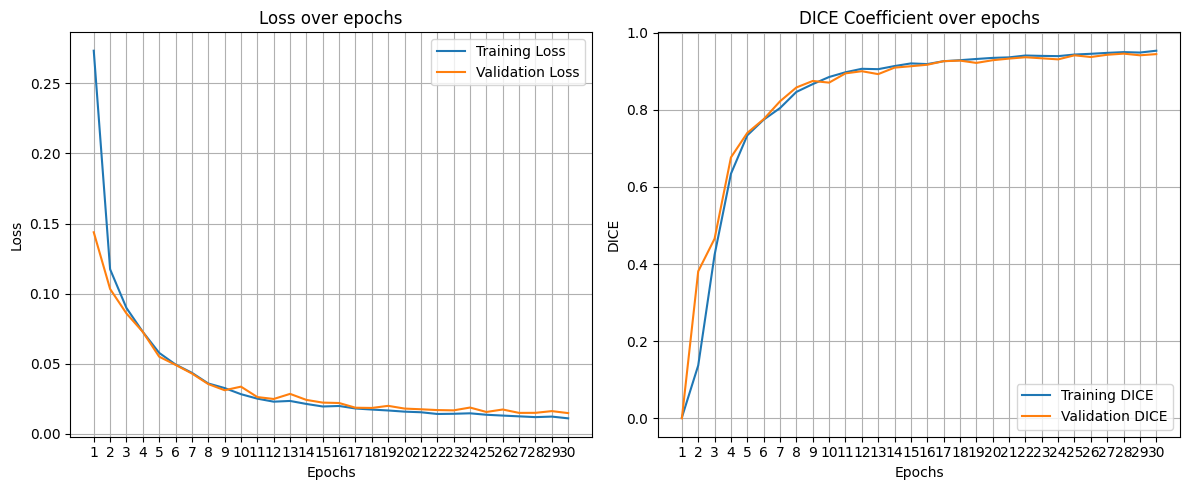

In [6]:
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1))) 
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.grid()
plt.tight_layout()

plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_dcs, label='Training DICE')
plt.plot(epochs_list, val_dcs, label='Validation DICE')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1)))  
plt.title('DICE Coefficient over epochs')
plt.xlabel('Epochs')
plt.ylabel('DICE')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
model_pth = '/kaggle/working/final/final_epoch30_fp16.pth'
trained_model = UNet(in_channels=3, num_classes=NUM_CLASS).half().to(device)
trained_model.load_state_dict(torch.load(model_pth,weights_only=True, map_location=torch.device(device)))

for name, param in trained_model.named_parameters():
    print(f"{name}: {param.dtype}")

down_convolution_1.conv.conv_op.0.weight: torch.float16
down_convolution_1.conv.conv_op.0.bias: torch.float16
down_convolution_1.conv.conv_op.2.weight: torch.float16
down_convolution_1.conv.conv_op.2.bias: torch.float16
down_convolution_2.conv.conv_op.0.weight: torch.float16
down_convolution_2.conv.conv_op.0.bias: torch.float16
down_convolution_2.conv.conv_op.2.weight: torch.float16
down_convolution_2.conv.conv_op.2.bias: torch.float16
down_convolution_3.conv.conv_op.0.weight: torch.float16
down_convolution_3.conv.conv_op.0.bias: torch.float16
down_convolution_3.conv.conv_op.2.weight: torch.float16
down_convolution_3.conv.conv_op.2.bias: torch.float16
down_convolution_4.conv.conv_op.0.weight: torch.float16
down_convolution_4.conv.conv_op.0.bias: torch.float16
down_convolution_4.conv.conv_op.2.weight: torch.float16
down_convolution_4.conv.conv_op.2.bias: torch.float16
bottle_neck.conv_op.0.weight: torch.float16
bottle_neck.conv_op.0.bias: torch.float16
bottle_neck.conv_op.2.weight: torc

In [8]:
test_running_loss = 0
test_running_dc = 0

with torch.no_grad():
    for idx, img_mask in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = img_mask[0].float().half().to(device)
        mask = img_mask[1].float().half().to(device)

        y_pred = trained_model(img)
        loss = criterion(y_pred, mask)
        dc = dice_coefficient(y_pred, mask)

        test_running_loss += loss.item()
        test_running_dc += dc.item()

    test_loss = test_running_loss / (idx + 1)
    test_dc = test_running_dc / (idx + 1)
print(f"{test_loss=}")
print(f"{test_dc=}")

100%|██████████| 6/6 [00:02<00:00,  2.66it/s]

test_loss=0.01251983642578125
test_dc=0.9463809132575989


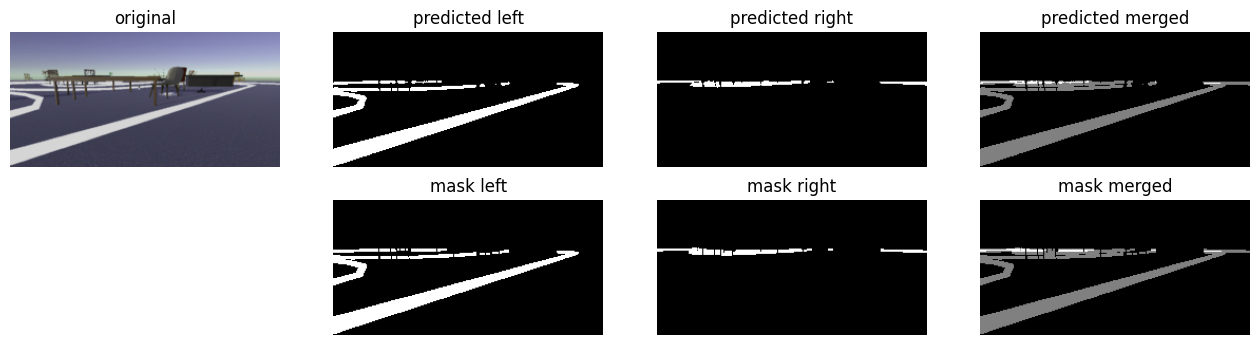

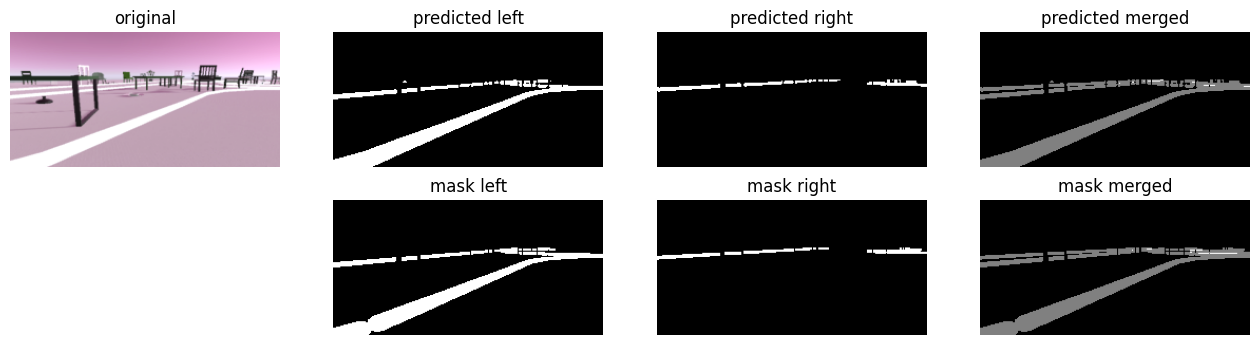

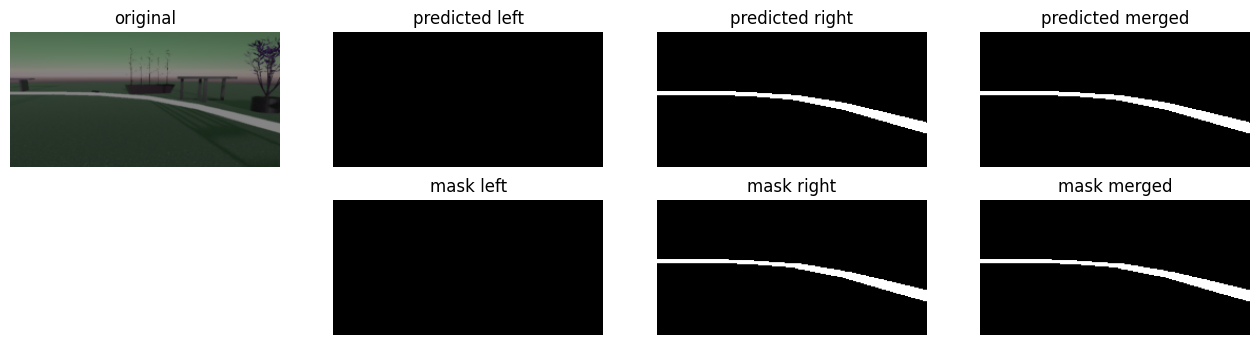

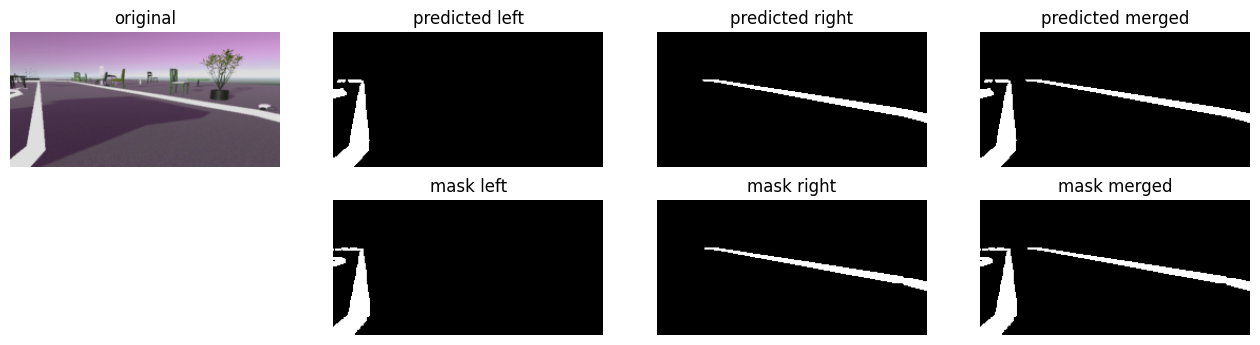

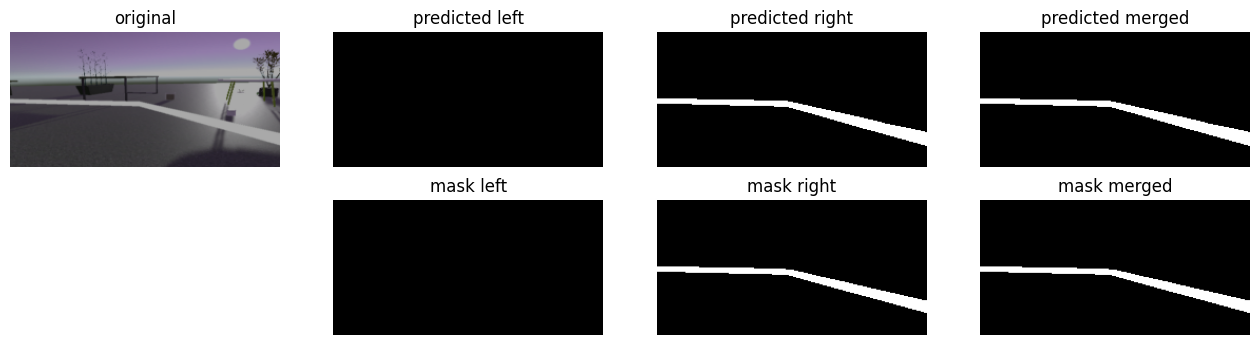

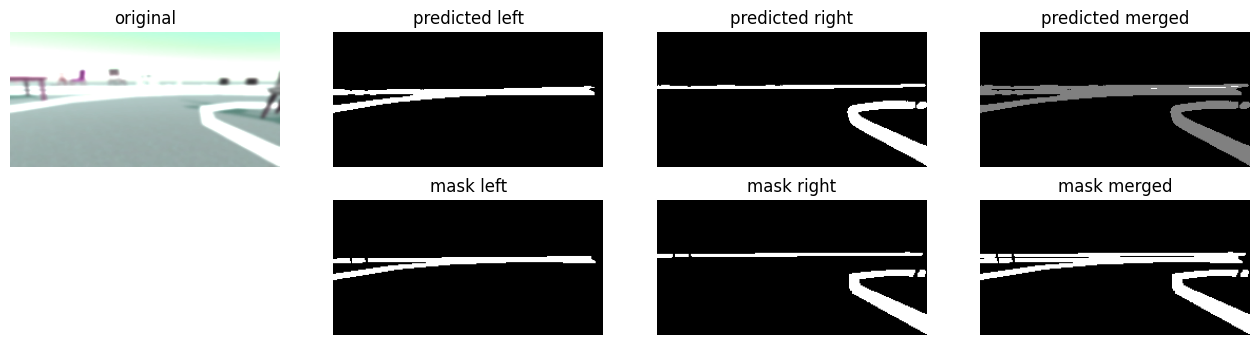

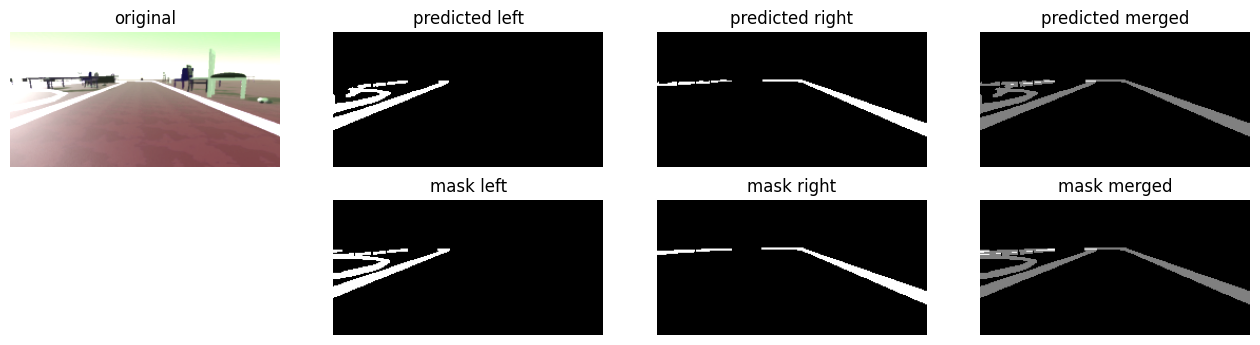

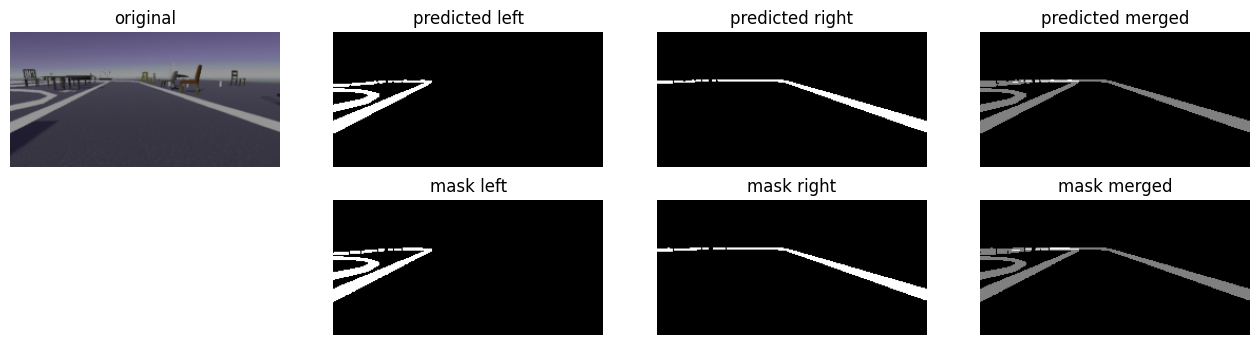

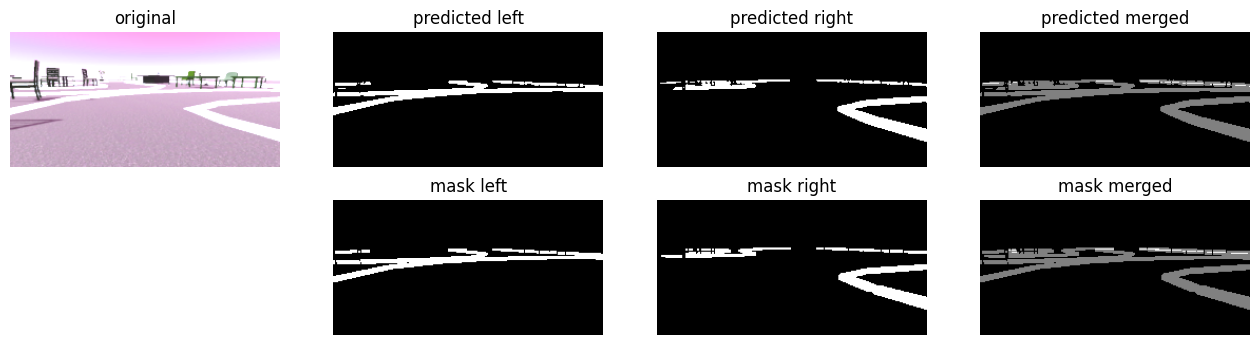

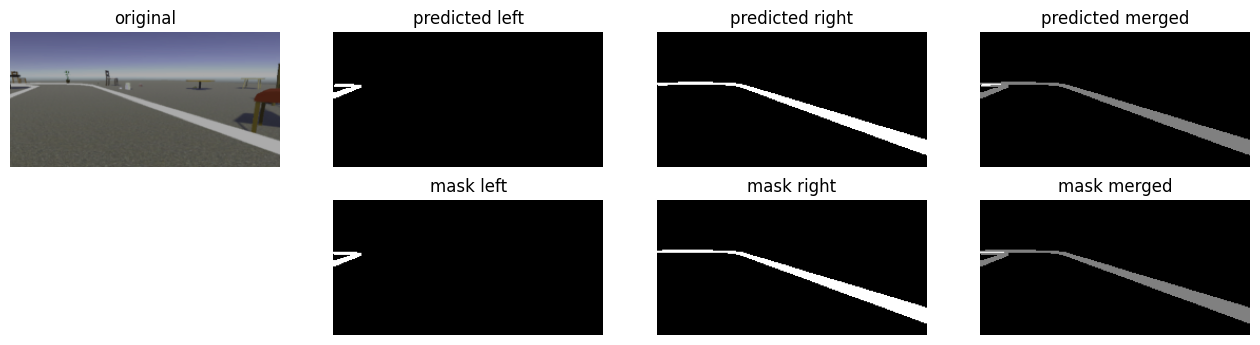

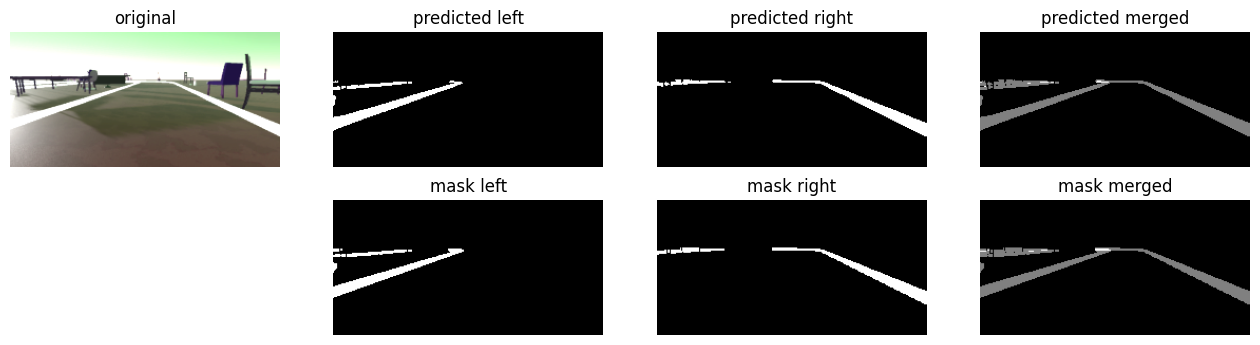

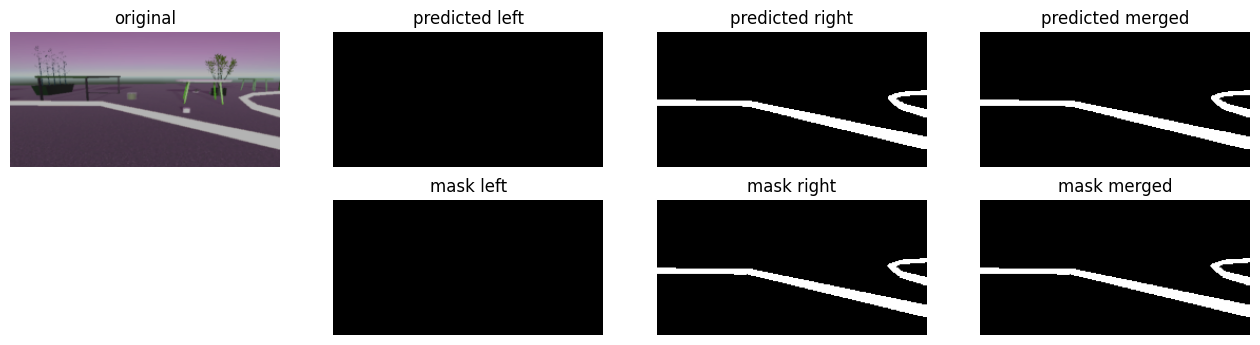

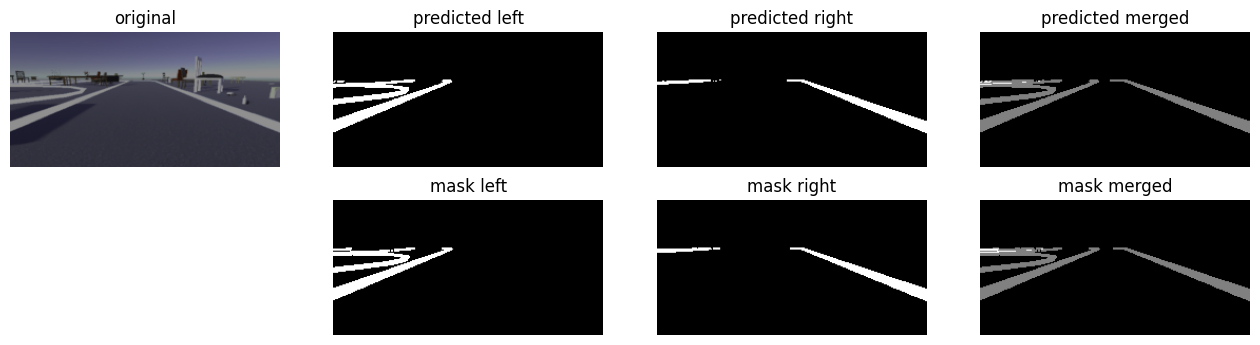

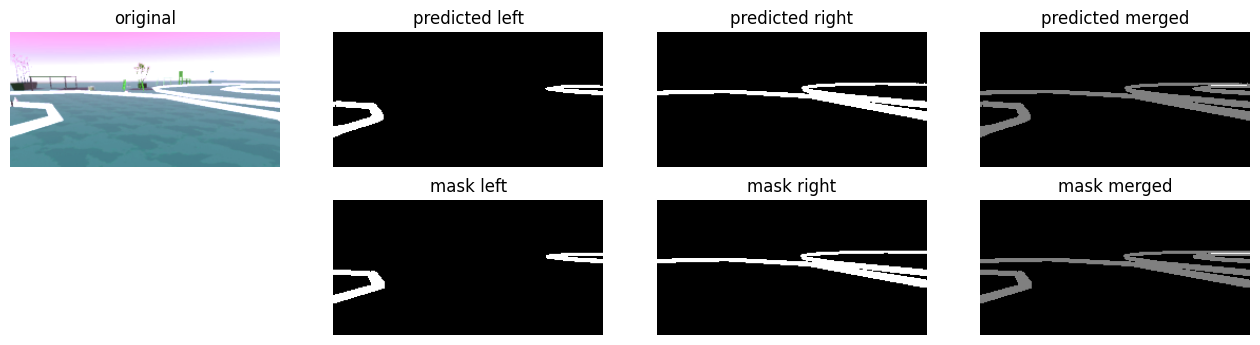

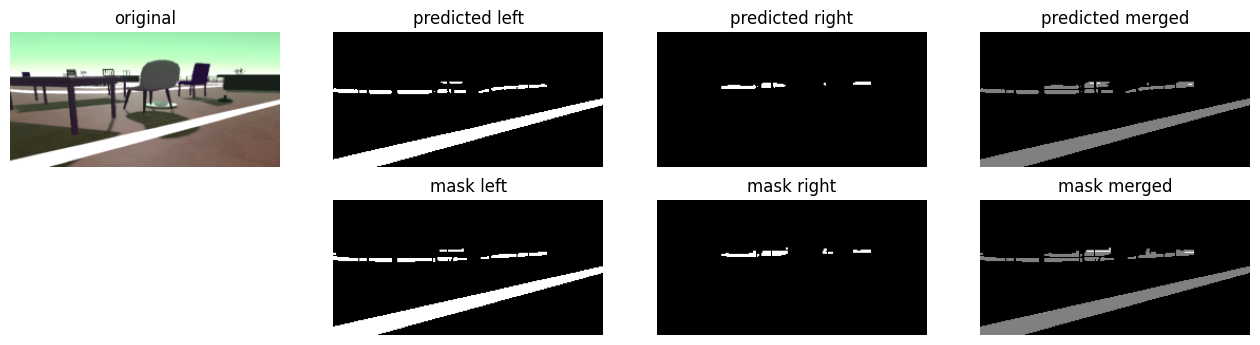

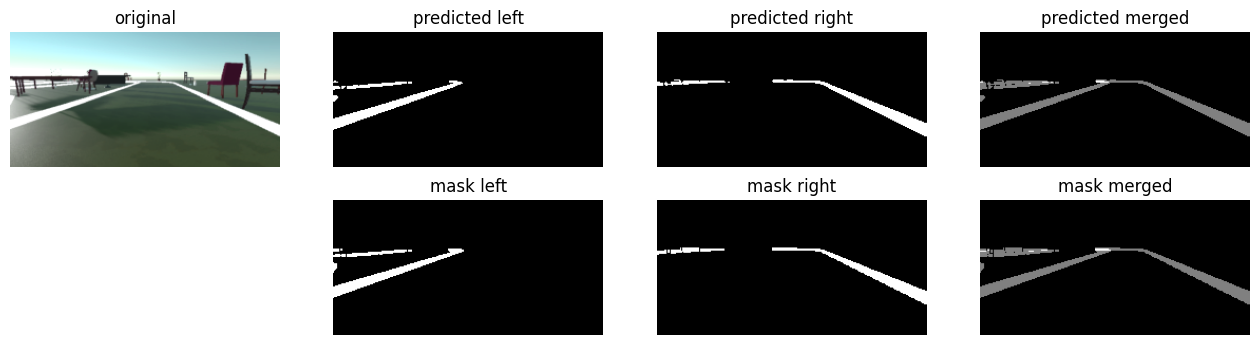

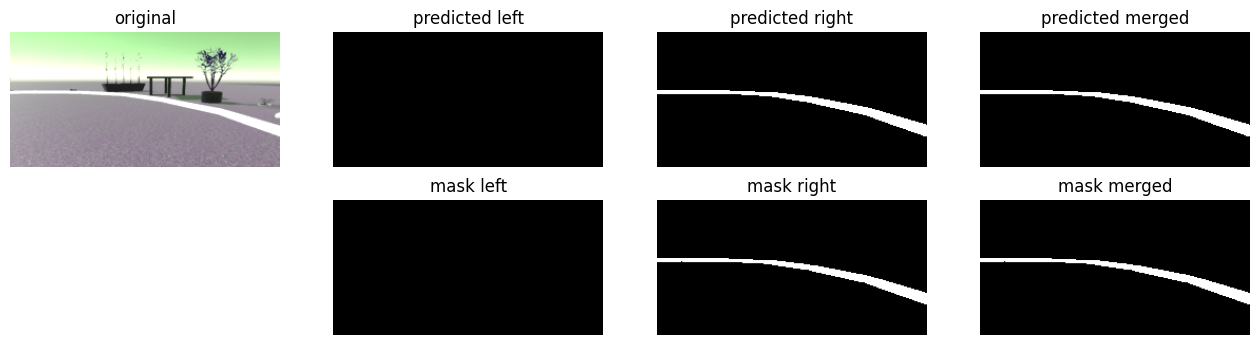

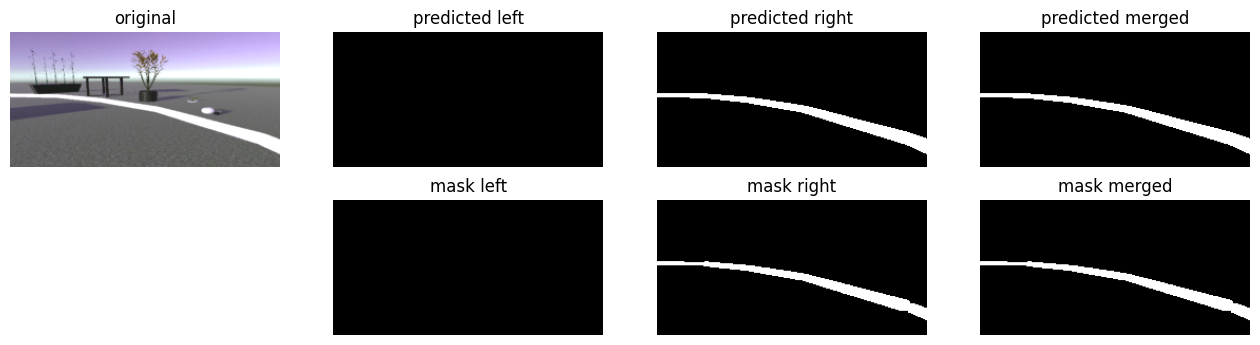

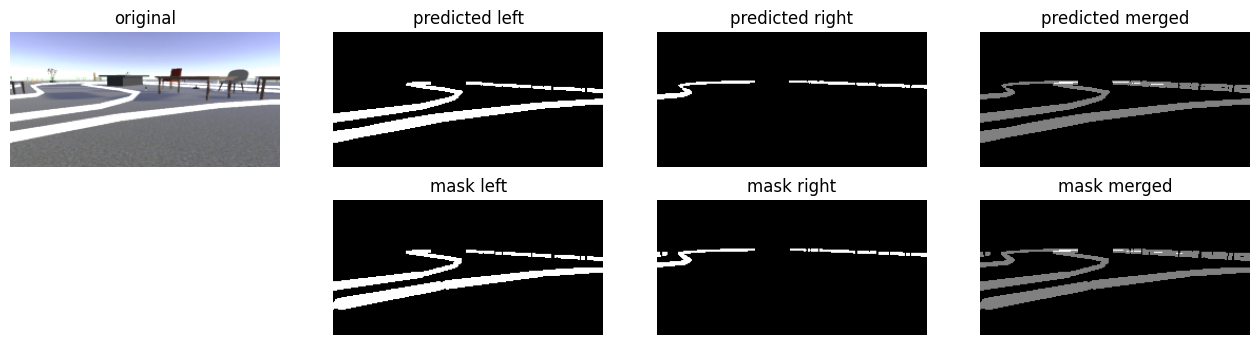

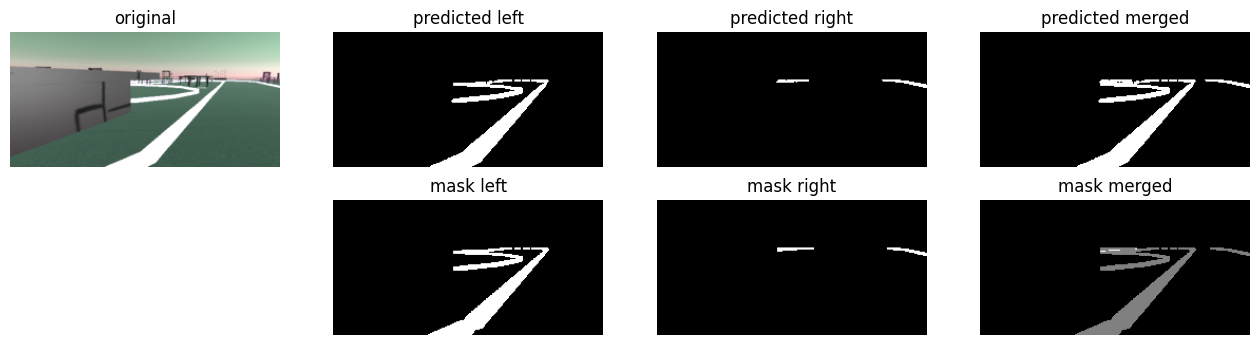

In [9]:
def random_images_inference(image_tensors, mask_tensors, model_pth, device):
    model = UNet(in_channels=3, num_classes=NUM_CLASS).half().to(device)
    model.load_state_dict(torch.load(model_pth, weights_only=True, map_location=torch.device(device)))

    transform = transforms.Compose([
        transforms.Resize(SIZE)
    ])

    # Iterate for the images, masks and paths
    for image_pth, mask_pth in zip(image_tensors, mask_tensors):
        # Load the image
        #img = image_pth
        img = transform(image_pth)
        
        # Predict the imagen with the model
        pred_mask = model(img.unsqueeze(0).float().half().to(device))
        pred_mask = pred_mask.squeeze(0) 
        pred_mask = pred_mask.permute(1,2,0)
        
        # Load the mask to compare
#        mask = transform(mask_pth).permute(1, 2, 0).to(device)
        mask = mask_pth.permute(1, 2, 0).cpu().detach()
        mask = mask.permute(2, 0, 1)
        merged_mask = mask[0] + mask[1]
        
        # Show the images
        img = img.cpu().detach().permute(1, 2, 0)
        pred_mask = pred_mask.cpu().detach()
        pred_mask = pred_mask.permute(2,0,1)
        pred_mask[0] = torch.sigmoid(pred_mask[0]) > 0.5
        pred_mask[1] = torch.sigmoid(pred_mask[1]) > 0.5
        merged_pred_mask = pred_mask[0] + pred_mask[1]

    
        plt.figure(figsize=(16, 4))
        plt.subplot(2,4,1), plt.imshow(img), plt.title("original"), plt.axis("off")
        plt.subplot(2,4,2), plt.imshow(pred_mask[0], cmap="gray"), plt.title("predicted left"), plt.axis("off")
        plt.subplot(2,4,3), plt.imshow(pred_mask[1], cmap="gray"), plt.title("predicted right"), plt.axis("off")
        plt.subplot(2,4,4), plt.imshow(merged_pred_mask, cmap="gray"), plt.title("predicted merged"), plt.axis("off")
        
        plt.subplot(2,4,6), plt.imshow(mask[0], cmap="gray"), plt.title("mask left"), plt.axis("off")
        plt.subplot(2,4,7), plt.imshow(mask[1], cmap="gray"), plt.title("mask right"), plt.axis("off")
        plt.subplot(2,4,8), plt.imshow(merged_mask, cmap="gray"), plt.title("mask merged"), plt.axis("off")
        plt.show()

n = 20

image_tensors = []
mask_tensors = []
image_paths = []

for _ in range(n):
    random_index = random.randint(0, len(test_dataloader.dataset) - 1)
    random_sample = test_dataloader.dataset[random_index]

    image_tensors.append(random_sample[0])  
    mask_tensors.append(random_sample[1])

model_path = '/kaggle/working/final/final_epoch30_fp16.pth'

random_images_inference(image_tensors, mask_tensors, model_path, device="cuda")




#resize nearest neighbor pour les mask